# Can we read model 1 V-J gene use count matrix PCs to see which V genes matter?

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
import seaborn as sns
import joblib
import gc

from malid.datamodels import GeneLocus, TargetObsColumnEnum
from malid.trained_model_wrappers import RepertoireClassifier
from malid import helpers, io

In [2]:
def interpret(
    gene_locus: GeneLocus, target_obs_column: TargetObsColumnEnum, fold_id: int
):
    clf_rep = RepertoireClassifier(
        fold_id=fold_id,
        model_name="lasso_multiclass",
        fold_label_train="train_smaller",
        gene_locus=gene_locus,
        target_obs_column=target_obs_column,
    )
    train_count_matrix_columns = joblib.load(
        clf_rep.models_base_dir
        / f"{clf_rep.fold_label_train}_model.{clf_rep.fold_id}.{clf_rep.fold_label_train}.specimen_vj_gene_counts_columns_joblib"
    )

    isotypes = helpers.isotype_groups_kept[gene_locus]
    # # sanity check:
    # isotypes, clf_rep.steps[0][
    #     1
    # ].named_transformers_.keys(), train_count_matrix_columns.keys()

    for isotype in isotypes:
        print(isotype)
        pca_transformer = (
            clf_rep.steps[0][1]
            .named_transformers_[f"log1p-scale-PCA_{isotype}"]
            .steps[-1][1]
        )

        # PCs x VJ pairs
        components_df = pd.DataFrame(
            pca_transformer.components_, columns=train_count_matrix_columns[isotype]
        )
        # display(components_df)

        # most important features for first PC component
        n_top = 10
        # display(components_df.iloc[0].abs().sort_values(ascending=False).head(n=n_top))

        # V genes in there
        print(
            components_df.iloc[0]
            .abs()
            .sort_values(ascending=False)
            .head(n=n_top)
            .index.str.split("|")
            .str[0]
            .unique()
        )

        # second PC coponent, same thing:
        print(
            components_df.iloc[1]
            .abs()
            .sort_values(ascending=False)
            .head(n=n_top)
            .index.str.split("|")
            .str[0]
            .unique()
        )

        print()
        print("*" * 60)
        print()

    adata = io.load_fold_embeddings(
        fold_id=fold_id,
        fold_label="train_smaller",
        gene_locus=gene_locus,
        target_obs_column=target_obs_column,
    )
    featurized = clf_rep.featurize(adata)

    # or use clf_rep._inner[:-1] if we want scaling added:
    pca_transformer = clf_rep.steps[0][1]
    transformed = pd.DataFrame(
        pca_transformer.transform(featurized.X),
        index=featurized.X.index,
        columns=pca_transformer.get_feature_names_out(),
    )
    # Show model 1's top 2 PCs of V/J gene use counts for train fold specimens
    for isotype in helpers.isotype_groups_kept[gene_locus]:
        plot_df = pd.concat(
            [
                transformed[
                    [
                        f"log1p-scale-PCA_{isotype}__pca0",
                        f"log1p-scale-PCA_{isotype}__pca1",
                    ]
                ].rename(
                    columns={
                        f"log1p-scale-PCA_{isotype}__pca0": "PC1",
                        f"log1p-scale-PCA_{isotype}__pca1": "PC2",
                    }
                ),
                featurized.metadata[["disease", "study_name"]],
            ],
            axis=1,
        )
        plot_df["Disease and batch"] = (
            plot_df["disease"].astype(str) + " - " + plot_df["study_name"].astype(str)
        )
        fig, ax = plt.subplots()
        sns.scatterplot(
            data=plot_df, x="PC1", y="PC2", hue="Disease and batch", ax=ax, alpha=0.7
        )
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        sns.despine(ax=ax)
        plt.title(f"{isotype} V-J gene use count PCA")

2023-01-07 04:11:39,110 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/fold.-1.train_smaller.h5ad -> /srv/scratch/maximz/cache/8cc5401fe377b72196e57b3b224e0e2f08d9ec61f1d5638f4c1dc03c.-1.train_smaller.h5ad


IGHG
Index(['IGHV3-23', 'IGHV4-b', 'IGHV1-2', 'IGHV4-39'], dtype='object', name='vgene_jgene')
Index(['IGHV1-24', 'IGHV1-18', 'IGHV1-46', 'IGHV3-30-3', 'IGHV3-9', 'IGHV1-8',
       'IGHV3-30', 'IGHV3-13'],
      dtype='object', name='vgene_jgene')

************************************************************

IGHA
Index(['IGHV4-b', 'IGHV4-4', 'IGHV3-23', 'IGHV4-39', 'IGHV3-33'], dtype='object', name='vgene_jgene')
Index(['IGHV1-18', 'IGHV1-8', 'IGHV1-24', 'IGHV3-7', 'IGHV4-34', 'IGHV1-2',
       'IGHV1-69'],
      dtype='object', name='vgene_jgene')

************************************************************

IGHD-M
Index(['IGHV3-23', 'IGHV4-34', 'IGHV1-46', 'IGHV3-21', 'IGHV4-b', 'IGHV4-59',
       'IGHV4-4'],
      dtype='object', name='vgene_jgene')
Index(['IGHV1-8', 'IGHV1-18', 'IGHV3-64', 'IGHV1-2', 'IGHV5-a', 'IGHV3-74'], dtype='object', name='vgene_jgene')

************************************************************

Only considering the two last: ['.train_smaller', '.h5ad'].

Only considering the two last: ['.train_smaller', '.h5ad'].


2023-01-07 04:17:32,590 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.-1.train_smaller.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


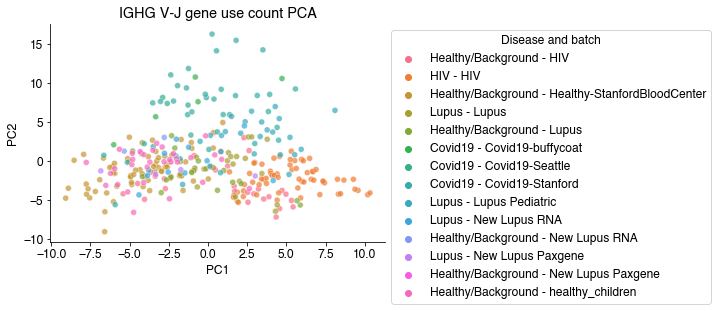

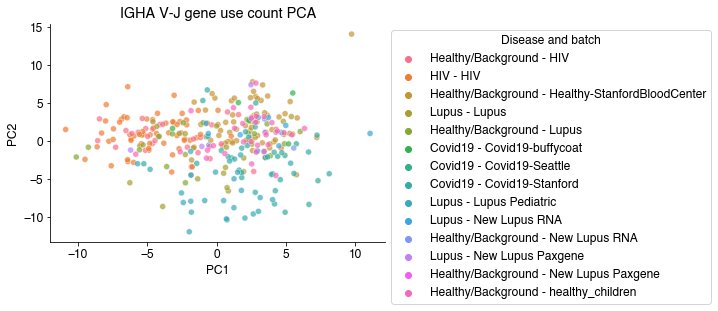

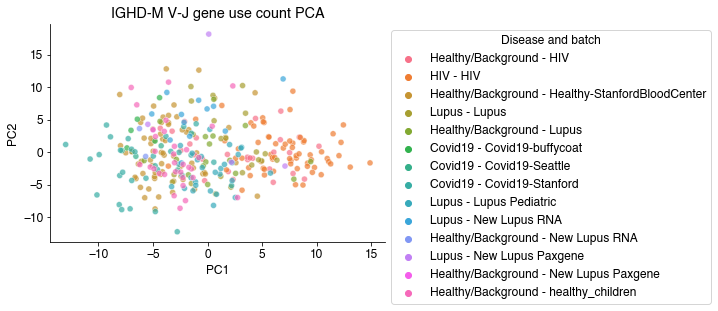

In [3]:
# also try TargetObsColumnEnum.covid_vs_healthy
interpret(
    gene_locus=GeneLocus.BCR, target_obs_column=TargetObsColumnEnum.disease, fold_id=-1
)

In [4]:
io.clear_cached_fold_embeddings()
gc.collect()

0

2023-01-07 04:19:24,257 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/fold.-1.train_smaller.h5ad -> /srv/scratch/maximz/cache/e7f386c8b7e4da1852d61ffaf2ab1bb59a3153f5c102f2978acd6d4c.-1.train_smaller.h5ad


TCRB
Index(['TRBV18', 'TRBV20-1', 'TRBV10-2', 'TRBV24-1'], dtype='object', name='vgene_jgene')
Index(['TRBV30', 'TRBV5-4'], dtype='object', name='vgene_jgene')

************************************************************

Only considering the two last: ['.train_smaller', '.h5ad'].


Only considering the two last: ['.train_smaller', '.h5ad'].


2023-01-07 04:27:00,233 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/neighborhoods/knn_neighborhood.-1.train_smaller.TCRB.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


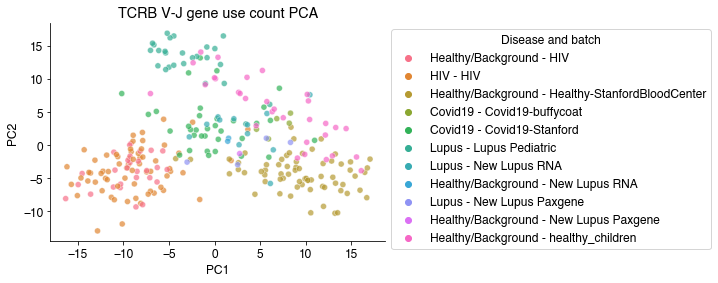

In [5]:
interpret(
    gene_locus=GeneLocus.TCR, target_obs_column=TargetObsColumnEnum.disease, fold_id=-1
)

In [6]:
io.clear_cached_fold_embeddings()
gc.collect()

0